# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMeasuredVsPredicted, plotScoresLoadings, clusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y")

header = ABC.columns
treatments = ABC.columns[3:13]

data = ABC.iloc[:, 3:13].T
protnames = ABC.iloc[:, 1]
seqs = ABC.iloc[:, 0]
prot_acc = ABC.iloc[:, 2]

### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

In [5]:
ncl = 2
pYTS = "Y"
GMMweight = 2.5
covariance_type = "diag" 
max_n_iter = 20

In [6]:
MSC = MassSpecClustering(seqs, protnames, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)
centers = MSC.transform(data)

In [7]:
MSC.transform(data)

,0,1
0,0.406167,0.909355
1,0.193589,0.402907
2,0.155271,0.232828
3,-0.373989,-0.458575
4,-0.039123,0.105755
5,-0.162553,-0.049063
6,0.016239,-0.053221
7,-0.170531,-0.379046
8,0.412881,-0.125579
9,-0.273466,-0.585361


In [8]:
from msresist.clustering import MyOwnKMEANS

kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers2 = kmeans.transform(data)

In [9]:
centers2

,0,1
0,1.363929,0.317719
1,0.598842,0.151542
2,0.405181,0.063051
3,-0.625201,-0.289812
4,0.191157,-0.029647
5,-0.058886,-0.096185
6,0.021941,-0.077507
7,-0.595391,-0.112386
8,-0.301752,0.269154
9,-0.999819,-0.116694


In [10]:
members = MSC.clustermembers(ABC.T)

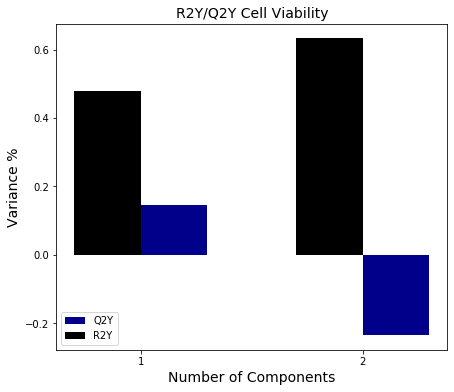

In [11]:
Q2Y = Q2Y_across_components(centers, Y_cv, ncl+1)
R2Y = R2Y_across_components(centers, Y_cv, ncl+1)

range_ = np.linspace(1, ncl, ncl)

fig, axs = plt.subplots(1,1, figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability", fontsize=14)
plt.ylabel("Variance %", fontsize=14)
plt.xlabel("Number of Components", fontsize=14)
plt.legend(loc=3)

In [12]:
# CVresults_max, CVresults_min, best_params = MSclusPLSR_tuning(data, seqs, protnames, Y_cv)
# CVresults_min.nlargest(30, "mean_test_scores")

In [13]:
# ncl_GMMweight_ncomp = CVresults_min.sort_values(by="Ranking")
# create_download_link(ncl_GMMweight_ncomp, "ncl_GMMweight_ncomp=2.csv")

Hyperparameter Tuning with Binomial Clustering:

In [14]:
pd.read_csv('./msresist/data/09252019-HyperparameterTuning_Binomial_ncl_GMMweight_ncomp.csv').iloc[:30, :11].iloc[:, 1:]

,Ranking,#Clusters,GMMweights,#ComponentsPLSR,mean_test_scores,mean_train_scores
0,1,2,2.5,2,-11.394670,-7.256597
1,2,2,5.0,2,-11.852214,-7.301871
2,3,2,0.5,2,-11.875249,-7.546528
3,4,4,2.5,1,-12.983479,-7.450285
4,5,5,2.5,1,-13.149582,-7.374562
5,6,5,0.5,1,-13.354861,-7.367209
6,7,6,0.5,1,-13.356816,-7.313067
7,8,7,2.5,1,-13.389536,-7.317714
8,9,3,2.5,1,-13.492450,-7.433888
9,10,4,5.0,1,-13.813688,-7.415974


Hyperparameter Tuning with PAM250 clustering (n_comp=2):

In [15]:
pd.read_csv('./msresist/data/10212019-HyperparameterTuning_PAM240_ncl_GMMweight_ncomp=2.csv').iloc[:30, :11].iloc[:, 1:]

,Ranking,#Clusters,GMMweights,mean_test_scores,mean_train_scores
0,1,2,0.5,-11.595917,-7.333136
1,2,2,7.5,-11.843382,-7.213930
2,3,2,5.0,-12.192753,-7.229445
3,4,2,2.5,-12.453907,-7.209936
4,5,3,0.5,-15.091032,-7.165148
5,6,10,0.5,-16.234995,-6.617000
6,7,8,0.5,-16.299599,-6.018821
7,8,2,10.0,-16.534765,-7.228141
8,9,4,7.5,-17.144144,-7.030176
9,10,4,0.5,-17.179267,-6.911445


In [16]:
ncl, GMMweight, ncomp = 2, 2.5, 2

In [17]:
mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(seqs, protnames, ncl, GMMweight=GMMweight, distance_method="PAM250")), ('plsr', PLSRegression(ncomp))])

In [18]:
X_scores, Y_scores = mixedCl_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = mixedCl_plsr.named_steps.plsr.x_loadings_[:, 0], mixedCl_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = mixedCl_plsr.named_steps.plsr.y_loadings_[:, 0], mixedCl_plsr.named_steps.plsr.y_loadings_[:, 1]

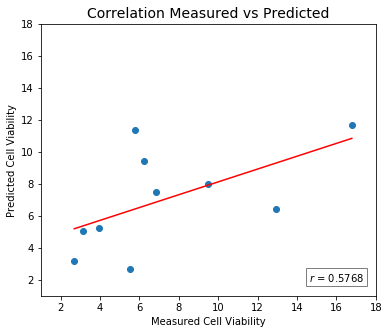

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)
plt.title("Correlation Measured vs Predicted", fontsize=14);

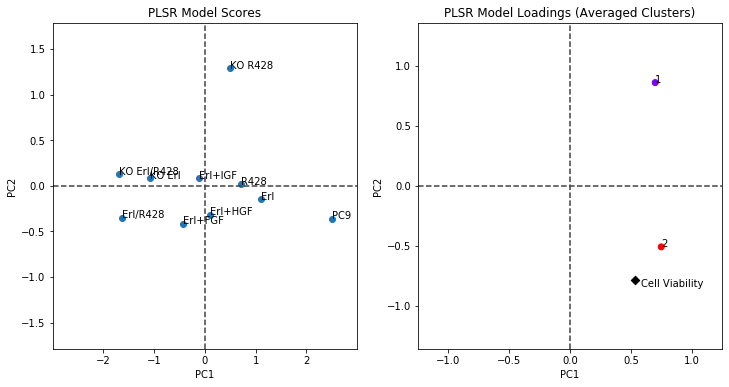

In [20]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([(-1*max(PC1_scores))-0.5, max(PC1_scores)+0.5])
axs[0].set_ylim([(-1*max(PC2_scores))-0.5, max(PC2_scores)+0.5])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].annotate("Cell Viability", (PC1_yload+0.05, PC2_yload-0.05))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
spacer = 0.5
axs[1].set_xlim([(-1*max(list(PC1_xload)+list(PC1_yload)))-spacer, max(list(PC1_xload)+list(PC1_yload))+spacer])
axs[1].set_ylim([(-1*max(list(PC2_xload)+list(PC2_yload)))-spacer, max(list(PC2_xload)+list(PC2_yload))+spacer]);

In [21]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,ProtAcc_Cluster_1,pos_Cluster_1,Cluster_2,seqs_Cluster_2,ProtAcc_Cluster_2,pos_Cluster_2
0,Heat shock 70 kDa protein 1A,AAAIAyGLDRT,P0DMV8,Y183-p,DNA replication licensing factor MCM7,AANPAyGRYNP,P33993,Y492-p
1,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,P54819,Y12-p,Kinesin light chain 2,AEEVEyYYRRA,Q9H0B6,Y345-p
2,Coactosin-like protein,ACRAAyNLVRD,Q14019,Y14-p,Receptor tyrosine-protein kinase erbB-2,AENPEyLGLDV,P04626,Y1248-p
3,Pyruvate kinase PKM,AEAAIyHLQLF,P14618,Y390-p,Protein-glutamine gamma-glutamyltransferase 2,AERDLyLENPE,P21980,Y583-p
4,Envoplakin,AEDAVyELQSK,Q92817,Y1352-p,ATPase WRNIP1,AGEEHyNCISA,Q96S55,Y500-p
...,...,...,...,...,...,...,...,...
206,NaN,NaN,NaN,NaN,Lipolysis-stimulated lipoprotein receptor,YAPSTyAHLSP,Q86X29,Y328-p
207,NaN,NaN,NaN,NaN,Paxillin,YCEKDyHNLFS,P49023,Y409-p
208,NaN,NaN,NaN,NaN,Golgin subfamily A member 4,YEKNVyATTVG,Q13439,Y2148-p
209,NaN,NaN,NaN,NaN,Glucose-6-phosphate 1-dehydrogenase,YRIDHyLGKEM,P11413,Y202-p


In [22]:
max([1,2,3])

3

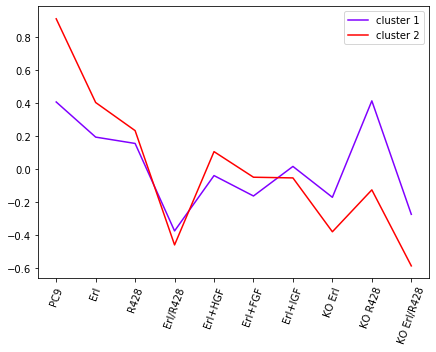

In [23]:
fig = plt.figure(figsize=(7,5))

centers = mixedCl_plsr.named_steps.mixedCl.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);